In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os # XXX not used
import numpy as np
import datetime
import glob
from sklearn import datasets, linear_model, ensemble, neural_network
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import random # XXX not used
from pathlib import Path

DOWNLOAD_DIR = '<your path here>'



In [3]:
DOWNLOAD_DIR = '../entsoe-data/'

In [4]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data = data.sort_values(by=["AreaName", "DateTime"])
    data = data.set_index("DateTime")

    print("Loading done.")

    return data


power_demand = load_complete_entso_e_data(DOWNLOAD_DIR)

Concatenating 68 csv files...
Loading done.


In [5]:
def get_hourly_country_data(data, country):
    ret_data = data[data["AreaName"] == country].interpolate()
    #ret_data = ret_data.set_index("DateTime")    XXX  remove line?
    ret_data = ret_data.resample("1h").mean().interpolate() # XXX why interpolating?
    return ret_data

power_demand_at_hourly = get_hourly_country_data(power_demand, "Austria")["2015-01-01":"2019-12-31"]

## Today's goal

We want to understand if electricity load is lower than expected due to the Corona Lockdown. We therefore have to know which electricity load we should have expected without the lockdown.

We do so by fitting a function to the electricity load.

## Exercise 1

What could we fit to the load - when you think of the last lecture? Which input features (i.e. data) is possibly strongly correlated with the load?

- a periodic function with periodicity 24h, 7 days or 1 year
- the data series itself

In [ ]:
# XXX maybe explain in written form what a feature is? better ask which kind of curves could be fitted
# with which kind of paramters?

In [4]:
# Put some potential features here... 

Let's do it!


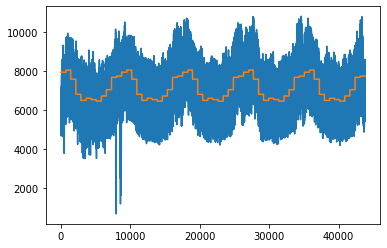

In [32]:
Y = power_demand_at_hourly["TotalLoadValue"].values
X = np.array(power_demand_at_hourly.index.month.values)[:, np.newaxis] # XXX np.array() not necessary

forest_simple = ensemble.RandomForestRegressor()

# Train the model using the training sets
forest_simple.fit(X, Y)

pred = forest_simple.predict(X)

plt.plot(Y)
plt.plot(pred)

In [8]:
np.newaxis? # XXX what is this?

SyntaxError: invalid syntax (<ipython-input-8-1d5ef5b70285>, line 1)

Hm... how could we do even better perhaps?

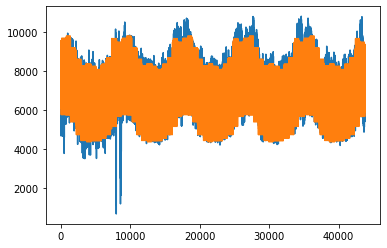

In [10]:
X = np.array([power_demand_at_hourly.index.month.values,
     power_demand_at_hourly.index.weekday.values,
     power_demand_at_hourly.index.hour.values]).T

# XXX this variable name has nothing to todo with "all month" and it's not very consistent to "forest_simple"
regr_all_month = ensemble.RandomForestRegressor()

# Train the model using the training sets
regr_all_month.fit(X, Y)

# XXX why not "predicition" as variable name?
pred = regr_all_month.predict(X)

plt.plot(Y)
plt.plot(pred)

In [15]:
Y.shape

(43824,)

Let's zoom in a bit...

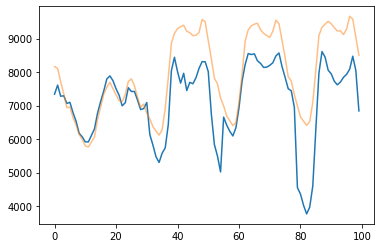

In [8]:
# XXX axis label missing, alpha not needed
plt.plot(Y[400:500])
plt.plot(pred[400:500], alpha=0.5)

Let's do it a little bit more correct:
you should train your data on a training data set and test it on a test data set.
If you do not do that, you may find an extremely good fit, but when you use new data on the algorithm, it may fail!


In [16]:
# XXX in one of the last reviews we discussed to use "training" instead of "train" to avoid
# confusion with the means of transportion, but not sure if necessary
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

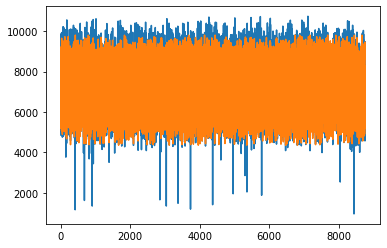

In [10]:
regr_split_set = ensemble.RandomForestRegressor()

# Train the model using the training sets
regr_split_set.fit(X_train, Y_train)

pred = regr_split_set.predict(X_test)

# XXX axis label missing... but i guess this is part of exercise 2 ;)
plt.plot(Y_test)
plt.plot(pred)

## Exercise 2

Why does this figure look different from the other load figures?

Because `train_test_split()` doesn't preserve the order as training might depend on order of samples.

Let's calculate a quality parameter for the fit...

In [11]:
pred_train = regr_split_set.predict(X_train)
pred_test = regr_split_set.predict(X_test)

print(r2_score(Y_train, pred_train))
print(r2_score(Y_test, pred_test))

0.8484103540188451
0.8126995541481195


Wowh, that's pretty good. And we are just using time information! That means we have pretty regular data.

## Exercise 3

Now redo the model, but instead of months use dayofyear for seasonal adjustment and remove weekday and hour. Calculate R2 if you predict with training data and calculate R2 if you predict with test data. What do you think, is quality improved?

In [40]:
X = power_demand_at_hourly.index.dayofyear.values[:, np.newaxis]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

random_forest = ensemble.RandomForestRegressor()
random_forest.fit(X_train, Y_train)

prediction_train = random_forest.predict(X_train)
prediction_test = random_forest.predict(X_test)

print(r2_score(Y_train, prediction_train))
print(r2_score(Y_test, prediction_test))

0.23422255278512072
0.22067530182086814


Pretty amazing fit! I think we can work with the model. # XXX the last fit of exercise 3 is not sooo good? maybe move the cell from below above this? or did i do something wrong?

Now let's look how this worked for 2020...

In [41]:
power_demand_at_hourly_2020 =  get_hourly_country_data(power_demand, "Austria")["2020-01-01":"2020-05-31"]

In [43]:
X = np.array([power_demand_at_hourly.index.dayofyear.values,
     power_demand_at_hourly.index.weekday.values,
     power_demand_at_hourly.index.hour.values]).T

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# XXX better name than above, but should be also consinstent.
regr_all_dayofyear = ensemble.RandomForestRegressor()

# Train the model using the training sets
regr_all_dayofyear.fit(X_train, Y_train)

pred_train = regr_all_dayofyear.predict(X_train)

pred_test = regr_all_dayofyear.predict(X_test)

print(r2_score(Y_train, pred_train))
print(r2_score(Y_test, pred_test))

0.9922570225636117
0.9373270324731012


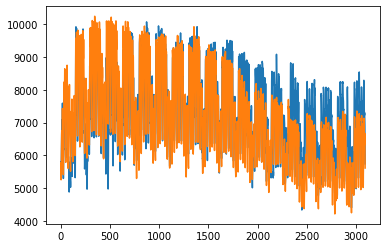

In [44]:
X_2020 = np.array([power_demand_at_hourly_2020.index.dayofyear.values,
     power_demand_at_hourly_2020.index.weekday.values,
     power_demand_at_hourly_2020.index.hour.values]).T

pred_2020 = regr_all_dayofyear.predict(X_2020)

# XXX missing axis label
plt.plot(pred_2020)
plt.plot(power_demand_at_hourly_2020["TotalLoadValue"].values)

## Exercise 4

Calculate the proportion of predicted vs. observed generation on a monthly basis and plot it! Hint: it is easier if you assign a new column to ```power_demand_at_hourly_2020``` with the predicted values from ```pred_2020```

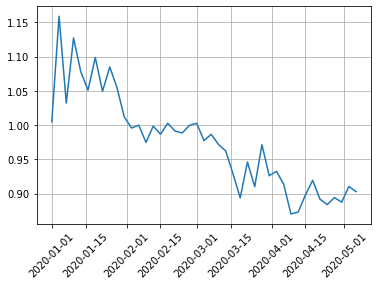

In [54]:
power_demand_at_hourly_2020["Predictions"] = pred_2020
power_demand_at_month_2020 = power_demand_at_hourly_2020.resample('3d').mean()  # 3d has more data than monthly

plt.plot(power_demand_at_month_2020["TotalLoadValue"]/power_demand_at_month_2020["Predictions"])
plt.xticks(rotation=45) # XXX adding this makes it nicer!
plt.grid();

In [ ]:
# XXX actually there is already a drop in early February? whut...?